In [1]:
import numpy as np
import geopandas as gpd
import pandas as pd
from scipy import stats as scipy_stats
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
import matplotlib.pyplot as plt
import rasterstats
from shapely.geometry import Polygon

Much of this notebook comes from: https://www.youtube.com/watch?v=VIr-pejky6E

## Bring in raster data

In [2]:
dsm_path = "../missoula_data/downtown_dsm.tif"
dsm = rasterio.open(dsm_path)
dsm.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -3.4028230607370965e+38,
 'width': 1571,
 'height': 1645,
 'count': 1,
 'crs': CRS.from_epsg(6514),
 'transform': Affine(0.9144000000087544, 0.0, 257075.3304003399,
        0.0, -0.9144000000087544, 301627.6416007468)}

## Bring in vector data

In [3]:
bldgs_path = "../missoula_data/downtown_bldgs.shp"
bldgs = gpd.read_file(bldgs_path).to_crs(6514)

In [4]:
bldgs

,fid,AVG_HEIGHT,MIN_LAG,area_sq_ft,geometry
0,1.0,27.32460,3202.73,44334.900,MULTIPOLYGON Z (((257091.482 300124.221 27.325...
1,2.0,11.80030,3204.72,5449.480,"POLYGON Z ((257170.740 300266.436 11.800, 2571..."
2,3.0,11.44360,3205.74,3658.490,"POLYGON Z ((257170.172 300185.933 11.444, 2571..."
3,4.0,30.45860,3205.99,13970.200,MULTIPOLYGON Z (((257408.449 300123.800 30.459...
4,5.0,10.99220,3204.42,6748.850,"POLYGON Z ((257175.485 300291.266 10.992, 2571..."
...,...,...,...,...,...
958,959.0,10.41030,3217.27,566.998,"POLYGON Z ((258263.976 301156.751 10.410, 2582..."
959,960.0,17.13810,3214.29,2976.740,"POLYGON Z ((258224.819 301179.597 17.138, 2582..."
960,961.0,16.08160,3217.24,1456.870,"POLYGON Z ((258300.759 301228.699 16.082, 2582..."
961,962.0,9.34612,3216.50,272.249,"POLYGON Z ((258217.425 301179.456 9.346, 25822..."


## Plot buildings and surface DEM

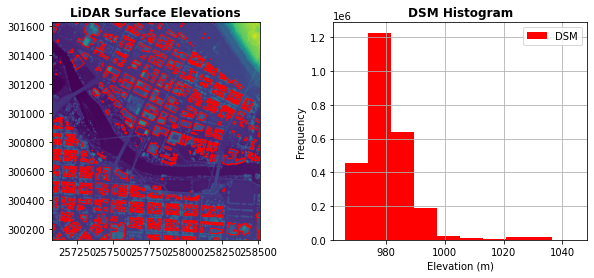

In [5]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
show(dsm, ax = ax1, title= 'LiDAR Surface Elevations')
bldgs.plot(ax = ax1, facecolor='None', edgecolor='red')
show_hist(dsm, title='DSM Histogram', ax=ax2, label='DSM')
ax2.set_xlabel('Elevation (m)')
plt.show()

## Calculate useable area

In [6]:
# Assign raster values to a numpy array
dsm_arr = dsm.read(1)
affine = dsm.transform
dsm.close()

# Majority functions
def numpy_majority(x):
    """
    I like this best because does not require extra library.
    This rounds the data to the nearest 10th of a meter first.

    returns majority value (i.e. mode)
    """

    x = x.filled(np.nan)
    x = np.round(x, 1)
    vals, counts = np.unique(x, return_counts=True)
    idx = np.argmax(counts)
    return float(vals[idx])

def scipy_majority(x):
    """Another way to do it."""
    x = x.filled(np.nan)
    return scipy_stats.mode(x, axis=None, nan_policy='omit')[0][0]

# Useable area function
def useable_area(x):
    """Calculates the area of the majority value (i.e. usable area)"""
    majority = numpy_majority(x)
    count_majority = ((x <= majority + 0.25) & (x >= majority - 0.25)).sum()
    return count_majority * affine[0] * -affine[4]

# Calculate zonal statistics
zstats = rasterstats.zonal_stats(bldgs, dsm_arr, affine=affine,
    nodata=dsm.nodata, geojson_out=True, add_stats={'useable_area': useable_area})

## Add useable area to geopandas dataframe

In [22]:
# Extract useable area from stats
ua = []
for bldg_stats in zstats:
    bldg_ua = (bldg_stats['properties']['fid'], bldg_stats['properties']['useable_area']*3.28084)
    ua.append(bldg_ua)

ua_df = gpd.GeoDataFrame(ua, columns=['fid', 'ua_sq_ft'])
full_data = pd.merge(bldgs, ua_df)

In [23]:
# Reorder columns 
cols = full_data.columns.tolist()
cols.insert(4, cols[-1])
full_data = full_data[cols[:-1]]

In [27]:
# Fix datatype issue
full_data = full_data.astype({'ua_sq_ft': np.float64}, copy=True)
full_data

,fid,AVG_HEIGHT,MIN_LAG,area_sq_ft,ua_sq_ft,geometry
0,1.0,27.32460,3202.73,44334.900,1108.252835,MULTIPOLYGON Z (((257091.482 300124.221 27.325...
1,2.0,11.80030,3204.72,5449.480,312.724810,"POLYGON Z ((257170.740 300266.436 11.800, 2571..."
2,3.0,11.44360,3205.74,3658.490,205.740007,"POLYGON Z ((257170.172 300185.933 11.444, 2571..."
3,4.0,30.45860,3205.99,13970.200,532.180817,MULTIPOLYGON Z (((257408.449 300123.800 30.459...
4,5.0,10.99220,3204.42,6748.850,480.060015,"POLYGON Z ((257175.485 300291.266 10.992, 2571..."
...,...,...,...,...,...,...
958,959.0,10.41030,3217.27,566.998,54.864002,"POLYGON Z ((258263.976 301156.751 10.410, 2582..."
959,960.0,17.13810,3214.29,2976.740,172.821606,"POLYGON Z ((258224.819 301179.597 17.138, 2582..."
960,961.0,16.08160,3217.24,1456.870,57.607202,"POLYGON Z ((258300.759 301228.699 16.082, 2582..."
961,962.0,9.34612,3216.50,272.249,27.432001,"POLYGON Z ((258217.425 301179.456 9.346, 25822..."


## Write to shapefile

In [25]:
full_data.to_file("../missoula_data/downtown_bldgs_ua.shp")